# Ensemble Learning

**Introduction to Ensemble Learning:**

Ensemble learning is a powerful technique in machine learning where multiple models, often called "weak learners," are combined to create a stronger, more accurate model. The main idea is that by aggregating the predictions of several models, we can achieve better performance than any single model could on its own.

Two popular and simple approaches to ensemble learning are **Bagging** and **Boosting**:

**Bagging (Bootstrap Aggregating):**
   - Bagging involves training multiple models independently on different random subsets of the training data. The final prediction is made by averaging the predictions of these models (for regression) or by voting (for classification). This method helps to reduce the variance of the model and prevent overfitting, particularly with high-variance models like decision trees.


**Boosting:**
   - Boosting, in contrast, trains models sequentially, with each new model focusing on correcting the errors made by the previous ones. The models are combined in such a way that the final ensemble model is a weighted sum of the individual models, where more weight is given to models that perform better. This process reduces both bias and variance, resulting in a strong overall model.



## Boosting

Suppose we have a weak classifier denoted as $ h_1 $, which is not performing well. The goal of boosting is to correct the mistakes made by $ h_1 $. To do this, we derive a new distribution $ D' $ from $ D $ that emphasizes the instances where $ h_1 $ makes errors. Using this new distribution $ D' $, we train a new classifier $ h_2 $.

By appropriately combining $ h_1 $ and $ h_2 $, we aim to create a better classifier. If the results are still unsatisfactory, we update the distribution and train a third classifier $ h_3 $. Combining $ h_1 $, $ h_2 $, and $ h_3 $ should result in a more accurate classifier, which is the final output of the algorithm.

Follow the algorithm below:

**Input:** Sample distribution $ D $;  
Base learning algorithm $ L $;  
Number of learning rounds $ T $.

**Process:**
1. $ D_1 = D $ \% Initialize the distribution.
2. For $ t = 1, \ldots, T $:
   - $ h_t = L(D_t) $ \% Train a weak learner from distribution $ D_t $.
   - $ \epsilon_t = P_{x \sim D_t}(h_t(x) \neq y) $ \% Evaluate the error of $ h_t $.
   - $ D_{t+1} = \text{Adjust Distribution}(D_t, t) $
3. Output: $ H(x) = \text{Combine\_Outputs}(\{h_1(x), \ldots, h_T(x)\}) $

## Homework : Correct following code 

The base learner must be selected such as Bayesian.

In [6]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Load the MNIST dataset from a local .npz file
mnist_data = np.load('..//mnist.npz')

# Extract the training and test sets
x_train = mnist_data['x_train']
y_train = mnist_data['y_train']
x_test = mnist_data['x_test']
y_test = mnist_data['y_test']

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# The dataset is already for digits 0 through 9, no need to filter
# The following are placeholders to ensure the training and test sets include all digits.

def base_learner(D_t):
    # Extract features and labels from the weighted distribution
    X = np.array([x for x, y, w in D_t])
    y = np.array([y for x, y, w in D_t])
    sample_weights = np.array([w for x, y, w in D_t])
    
    # Train a Naive Bayes classifier
    clf = GaussianNB()
    clf.fit(X, y, sample_weight=sample_weights)
    
    # Return a function that makes predictions using the trained model
    return lambda x: clf.predict([x])[0], clf

def adjust_distribution(D_t, h_t, epsilon_t):
    # Adjust the distribution based on the error rate epsilon_t
    new_D = []
    for x, y, w in D_t:
        if h_t(x) != y:
            w *= np.exp(epsilon_t)
        new_D.append((x, y, w))
    
    # Normalize weights
    total_weight = sum(w for _, _, w in new_D)
    new_D = [(x, y, w/total_weight) for x, y, w in new_D]
    
    return new_D

def combine_outputs(weak_learners, x):
    # Majority voting for the final classifier
    votes = np.zeros(10)  # For 10 classes
    for h in weak_learners:
        prediction = h(x)
        votes[prediction] += 1
    return np.argmax(votes)

def boosting(D, L, T):
    # Initialize distribution with equal weights
    D_t = [(x, y, 1/len(D)) for x, y in D]
    weak_learners = []
    base_learner_accuracies = []

    for t in range(T):
        # Train a weak learner on the current distribution
        h_t, clf = L(D_t)
        weak_learners.append(h_t)
        
        # Evaluate the error of the weak learner
        epsilon_t = sum(w for (x, y, w) in D_t if h_t(x) != y)
        
        # Calculate accuracy of the current weak learner
        predictions = clf.predict(x_train)
        accuracy = accuracy_score(y_train, predictions)
        base_learner_accuracies.append(accuracy)
        print(f"Weak Learner {t + 1} Accuracy: {accuracy:.4f}")

        # Adjust the distribution based on the error
        D_t = adjust_distribution(D_t, h_t, epsilon_t)
    
    # Combine outputs of all weak learners
    return lambda x: combine_outputs(weak_learners, x), base_learner_accuracies

# Prepare the training data for boosting
D_train = [(x, y) for x, y in zip(x_train, y_train)]

# Number of boosting rounds
T = 10

# Train the boosted classifier
H, base_learner_accuracies = boosting(D_train, base_learner, T)

# Evaluate the final model on the test set
y_pred = [H(x) for x in x_test]

# Calculate the accuracy of the final model
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Model Accuracy on the test set:", final_accuracy)

# Compare accuracies
print("Base Learner Accuracies:", base_learner_accuracies)


Weak Learner 1 Accuracy: 0.5649
Weak Learner 2 Accuracy: 0.5620
Weak Learner 3 Accuracy: 0.5594
Weak Learner 4 Accuracy: 0.5657
Weak Learner 5 Accuracy: 0.5784
Weak Learner 6 Accuracy: 0.5947
Weak Learner 7 Accuracy: 0.5839
Weak Learner 8 Accuracy: 0.5741
Weak Learner 9 Accuracy: 0.5324
Weak Learner 10 Accuracy: 0.5622
Final Model Accuracy on the test set: 0.597
Base Learner Accuracies: [0.5649, 0.5620166666666667, 0.5593666666666667, 0.5657166666666666, 0.5783666666666667, 0.5947333333333333, 0.5838666666666666, 0.5741, 0.5324333333333333, 0.5621666666666667]


### The AdaBoost method

The general boosting procedure described above requires two key operations: `Adjust_Distribution` and `Combine_Outputs`.

The cost function we aim to minimize for a classifier involves both the parameters of the classifier and the weights of each classifier used in the combination. The cost function is given by:

$$
J(\theta, \alpha) = E[l(e)] + \lambda G(\theta, \alpha)
$$

where $ e $ is the error, $ l $ is the loss function, $ \theta $ represents the parameters of the classifier, and $ \alpha $ denotes the weights for combining the classifiers. $ G(\theta, \alpha) $ is used for sparsification.

For a two-class classifier, the error $ e $ can be represented as $ e = y g(x) $, where $ g(x) $ is the decision function. The cost function $ J(\theta, \alpha) $ is expressed as:

$$
J(\theta, \alpha) = \sum_{i=1}^{n} \exp(-y_i h_m(x_i))
$$

Here, $ h_m(x_i) $ is the decision function at the $ m $-th iteration. The decision function $ H(x) $ consists of kernel functions $ h(x) $ and weight combinations $ \alpha $. The decision function for the $ m $-th iteration is given by:

$$
H_{(m)}(x) = \sum_{j=1}^{m} \alpha_j h_j(x)
$$

then, 

$$
H_{(m)}(x) = H_{(m-1)}(x) + \alpha_m h_m(x)
$$

This expression shows that $ H_{(m)}(x) $ is incrementally updated in each boosting iteration.

The cost function can be further expanded as follows:

$$
J(\theta, \alpha) = \sum_{i=1}^{n} \exp(-y_i H_{(m)}(x_i))
$$

Substituting $ h_m(x_i) $ into the expression:

$$
J(\theta, \alpha) = \sum_{i=1}^{n} \exp(-y_i \cdot  (H_{(m-1)}(x_i) + \alpha_m h_m(x_i)))
$$

This can be rewritten as:

$$
J(\theta, \alpha) = \sum_{i=1}^{n} \exp(-y_i H_{(m-1)}(x_i)) \cdot \exp(-y_i \alpha_m h_m(x_i))
$$

or:

$$
J(\theta, \alpha) = \sum_{i=1}^{n} w_i^m \cdot \exp(-y_i \alpha_m h_m(x_i))
$$

where $ w_i^m = \exp(-y_i h_{(m-1)}(x_i))$ represents the weight of the sample $ x_i $ at iteration $ m $.

**Given:**

- For correctly classified samples: $ y_i h_m(x_i) = 1 $
- For misclassified samples: $ y_i h_m(x_i) = -1 $

The cost function $ J(\theta, \alpha) $ can be split into contributions from correctly classified samples $\Omega_1$ and misclassified samples $\Omega_2$.

**The general formula for $ J(\theta, \alpha) $ is:**

$$
J(\theta, \alpha) = \sum_{i=1}^{n} w_i^m \cdot \exp(-y_i \alpha_m h_m(x_i))
$$

**For correctly classified samples $\Omega_1$:**

In this case, $ y_i h_m(x_i) = 1 $. Therefore:

$$
\exp(-y_i \alpha_m h_m(x_i)) = \exp(-\alpha_m)
$$

Thus, the contribution to $ J(\theta, \alpha) $ from correctly classified samples is:

$$
\sum_{i \in \Omega_1} w_i^m \cdot \exp(-\alpha_m)
$$

**For misclassified samples $\Omega_2$:**

In this case, $ y_i h_m(x_i) = -1 $. Therefore:

$$
\exp(-y_i \alpha_m h_m(x_i)) = \exp(\alpha_m)
$$

Thus, the contribution to $ J(\theta, \alpha) $ from misclassified samples is:

$$
\sum_{i \in \Omega_2} w_i^m \cdot \exp(\alpha_m)
$$

**Combining both contributions:**

$$
J(\theta, \alpha) = \sum_{i \in \Omega_1} w_i^m \cdot \exp(-\alpha_m) + \sum_{i \in \Omega_2} w_i^m \cdot \exp(\alpha_m)
$$

### Weights of combination

Given the definitions:

- $ B = F_C(m) $ (true classifications)
- $ A = T_C(m) $ (false classifications)

and using the error rate definition:

$$
\epsilon_m = \frac{F_C(m)}{F_C(m) + T_C(m)}
$$

we can substitute these into the derivative calculation.

**Rewrite $ A $ and $ B $**

Substitute $ A $ and $ B $ into the equation:

$$
\exp(-2\alpha_m) = \frac{B}{A}
$$

which becomes:

$$
\exp(-2\alpha_m) = \frac{F_C(m)}{T_C(m)}
$$

**Express $ \epsilon_m $ in Terms of $ F_C(m) $ and $ T_C(m) $**

From the definition of $ \epsilon_m $:

$$
\epsilon_m = \frac{F_C(m)}{F_C(m) + T_C(m)}
$$

Rearrange to express $ F_C(m) $ in terms of $ \epsilon_m $ and $ T_C(m) $:

$$
F_C(m) = \epsilon_m \cdot (F_C(m) + T_C(m))
$$

Solve for $ F_C(m) $:

$$
F_C(m) = \epsilon_m \cdot (F_C(m) + T_C(m))
$$

$$
F_C(m) = \epsilon_m \cdot \frac{1}{1 - \epsilon_m} \cdot T_C(m)
$$

So:

$$
\frac{F_C(m)}{T_C(m)} = \frac{\epsilon_m}{1 - \epsilon_m}
$$

**Substitute into the Exponential Term**

Now substitute this into the exponential term:

$$
\exp(-2\alpha_m) = \frac{F_C(m)}{T_C(m)}
$$

$$
\exp(-2\alpha_m) = \frac{\epsilon_m}{1 - \epsilon_m}
$$

**Solve for $ \alpha_m $**

Taking the natural logarithm of both sides:

$$
-2\alpha_m = \ln\left(\frac{\epsilon_m}{1 - \epsilon_m}\right)
$$

So:

$$
\alpha_m = -\frac{1}{2} \ln\left(\frac{\epsilon_m}{1 - \epsilon_m}\right)
$$

![Alpha Adaboost Curve](../EnsembleLearning/EnsembleLearningImage/AlphaAdaboost.PNG)

$$
l_{\exp}(H_{m-1}(x) + h_m(x) \mid D) = \mathbb{E}_{x \sim D}\left[\exp\left(-y \cdot (H_{m-1}(x) + h_m(x))\right)\right] 
$$

$$
=\mathbb{E}_{x \sim D}\left[e^{-y H_{m-1}(x)} e^{-y h_m(x)}\right]
$$

Using Taylor expansion of $ e^{-yh_{m}(x)} $
the exponential loss is approximated by:

$$
\exp(H_{m-1} + h_m \mid \mathcal{D}) \approx \mathbb{E}_{x \sim \mathcal{D}} \left[ e^{-yH_{m-1}(x)}  \left( 1 - y h_m(x) + \frac{y^2}{2} h_m(x)^2 \right) \right]
$$

$$
\text{By noticing that } y^2 = 1 \text{ and } h_m(x)^2 = 1, \text{ the ideal classifier } h_m \text{ is}
$$

desired classifier $ h_m(x) $

$$
h_m(x) = \arg\min_{h} \left\{\ell _{\exp}(H_{m-1} + h \mid D) \right\}
$$

$$
\begin{align*}
& =\arg\min_h \  \mathbb{E}_{x \sim D} \left[ e^{-y H_{m-1}(x)} \left(1 - y h(x)\right) + \frac{1}{2} \right] \\
& = \arg\max_h \ \mathbb{E}_{x \sim D} \left[ e^{-y H_{m-1}(x)} y h(x) \right] \\
& = \arg\max_h \ \mathbb{E}_{x \sim D} \left[ e^{-y H_{m-1}(x)}  y h(x)\right]
\end{align*}
$$

by noticing that 
$$
\ \mathbb{E}_{x \sim D} \left[ e^{-y H_{m-1}(x)}\right]
$$ 
is a constant.

$$
\begin{align*}
& = \arg\max_h \ \mathbb{E}_{x \sim D} \left[ \frac{e^{-y H_{m-1}(x)}}{\ \mathbb{E}_{x \sim D} \left[ e^{-y H_{m-1}(x)}\right]} y h(x) \right]
\end{align*}
$$

Denote a distribution
$$
\mathcal{D}_m(x)=\ \frac{\mathcal{D}(x)e^{-y H_{m-1}(x)}}{\ \mathbb{E}_{x \sim D} \left[ e^{-y H_{m-1}(x)}\right]}
$$

$$
h_m(x) = \arg\max_h \ \mathbb{E}_{x \sim D_m} \left[ y h(x)  \right]
$$

In the expression $ y h_m(x) = 1 - 2 \mathbb{I} (y \neq h_m(x)) $, where $ y $ is the true label and $ h_m(x) $ is the predicted label, the term $ \mathbb{I}(y \neq h_m(x)) $ is an indicator function that equals 1 if the true label $ y $ does not match the predicted label $ h_m(x) $, and 0 if they are the same.

$ 1 - 2 \mathbb{I}(y \neq h_m(x)) $:
- If $ y = h_m(x) $: $ \mathbb{I}(y \neq h_m(x)) = 0 $, so the expression becomes $ 1 - 2 \times 0 = 1 $.
- If $ y \neq h_m(x) $: $ \mathbb{I}(y \neq h_m(x)) = 1 $, so the expression becomes $ 1 - 2 \times 1 = -1 $.

Therefore:
   - When the prediction $ h_m(x) $ is correct, the expression $ y h_m(x) $ equals 1.
   - When the prediction $ h_m(x) $ is incorrect, the expression $ y h_m(x) $ equals -1.

The ideal classifier is: 

$$
h_m(x)=\arg\min_h \ \mathbb{E}_{x \sim D_m} \left[ \mathbb{I}(y \neq h(x)) \right]
$$

As can be seen, the ideal $ h_m $ minimizes the classification error under the distribution $ D_m $. Therefore, the weak learner is to be trained under $ D_m $, and has less than 0.5 classification error according to $ D_m $ (For $ y h_m(x) >0 $ that $ y h_m(x) = 1 - 2 \mathbb{I} (y \neq h_m(x)) $). Considering the relationship between $ D_m $ and $ D_{m+1} $ we have:

$$
\mathcal{D}_{m+1}(x) = \frac{D(x) e^{-y H_m(x)}}{\mathbb{E}_{x \sim D_m} \left[ e^{-y H_m(x)} \right]}
$$

$$
= \frac{D(x) e^{-y H_{m-1}(x)} e^{-y \alpha_m h_m(x)}}{\mathbb{E}_{x \sim D_t} \left[ e^{-y H_m(x)} \right]} 
$$

$$
= D_m(x) \cdot e^{-y \alpha_t h_m(x)} \frac{\mathbb{E}_{x \sim D_m} \left[ e^{-y H_{m-1}(x)} \right]}{\mathbb{E}_{x \sim D_m} \left[ e^{-y H_m(x)} \right]}
$$

$$
\frac{1}{Z_m}=\frac{\mathbb{E}_{x \sim D_m} \left[ e^{-y H_{m-1}(x)} \right]}{\mathbb{E}_{x \sim D_m} \left[ e^{-y H_m(x)} \right]}
$$


$$
\mathcal{D}_{m+1}(x) =\frac{D_m(x) \cdot e^{-y \alpha_t h_m(x)}}{Z_m}
$$

Here, $\frac{1}{Z_m} $ is a normalization factor. Therefore $D_m(x) \cdot e^{-y \alpha_t h_m(x)}$ is then calculated with,

$$
Z_m=\sum_{m}(D_m(x) \cdot e^{-y \alpha_t h_m(x)})
$$

$$
\textbf{Note:} 
$$

If $\epsilon_m > 0.5$, then

$$
\alpha_m = -\frac{1}{2} \ln\left(\frac{\epsilon_m}{1 - \epsilon_m}\right)
$$

Thus, $\alpha_m < 0$. Consequently, there are a few possible scenarios:
1. $\alpha_m = 0$
2. $\epsilon_m = 1 - \epsilon_m$, which $\alpha $ is calculated as follow,

$$
\alpha_m = \frac{1}{2} \ln\left(\frac{\epsilon_m}{1 - \epsilon_m}\right)
$$


### Adaboost Algorithm

**Input:**  
- Dataset $ D = \{(x_1, y_1), (x_2, y_2), \dots, (x_m, y_m)\} $
- Base learning algorithm $ L $
- Number of learning rounds $ T $

**Process:**  
1. Initialize the weight distribution $ D_1(x) = \frac{1}{m} $.
2. For $ t = 1, \dots, T $:
   - Train a classifier $ h_t $ using the base algorithm $ L $ on dataset $ D $ under the distribution $ D_t $.
   - Calculate the error $ \epsilon_t $ of $ h_t $, where $ \epsilon_t = P_{x \sim D_t}(h_t(x) \neq f(x)) $.
   - If $ \epsilon_t > 0.5 $, then $\alpha_t=0$ and continue,
   - Determine the weight $ \alpha_t = \frac{1}{2} \ln \left(\frac{1 - \epsilon_t}{\epsilon_t}\right) $ of the classifier $ h_t $.
   - Update the distribution for the next round:
     $$
     D_{t+1}(x) = \frac{D_t(x) \exp(-\alpha_t f(x) h_t(x))}{Z_t}
     $$
     where $ Z_t $ is a normalization factor that ensures $ D_{t+1} $ is a valid distribution.
3. End the loop.

**Output:**  
The final hypothesis is given by $ H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right) $.


### How its work Adaboost

![How its work Adaboost1](../EnsembleLearning/EnsembleLearningImage/HowItsWorkAdaboost.png)


e:\HadiSadoghiYazdi\.M_HomePage\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


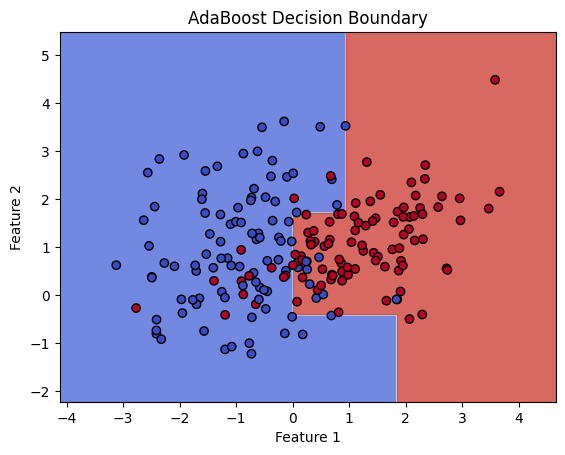

In [6]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Generate synthetic 2D dataset
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, flip_y=0, random_state=42)

# Initialize base classifier
base_classifier = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost classifier
adaboost = AdaBoostClassifier(base_classifier, n_estimators=5, algorithm='SAMME.R', random_state=42)

# Fit AdaBoost classifier to the data
adaboost.fit(X, y)

# Predict using the fitted model
y_pred = adaboost.predict(X)

# Plot the decision boundary
def plot_decision_boundary(X, y, model):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', cmap=plt.cm.coolwarm)
    plt.title('AdaBoost Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot the decision boundary
plot_decision_boundary(X, y, adaboost)


## Homework : Adaboost
- Play with diferent n_estimators
- write adaboost without sklearn.ensemble

### What we do with AdaBoost
What we do with AdaBoost can be explained by first reviewing the following works we have mentioned:

1) **Bahraini, T., Hosseini, S. M., Ghasempour, M., & Sadoghi Yazdi, H.** (2022). Density-oriented linear discriminant analysis. *Expert Systems with Applications, 187*, 115946.  

In the study "Density-oriented linear discriminant analysis," the authors tackle big data challenges by integrating AdaBoost with a novel base learner, DLDA (Density-Oriented Linear Discriminant Analysis). This combination enhances classification accuracy and efficiency, especially in high-dimensional and imbalanced datasets. The approach is scalable and suitable for various big data applications, offering an innovative solution to improve machine learning performance in complex environments. Future work includes optimizing DLDA and exploring integrations with other advanced techniques.

## Miniproject: The LogitBoost algorithm

## Miniproject: The LPBoost algorithm

## Bagging

Bagging, short for Bootstrap Aggregating, reduces errors by combining multiple independent base learners. It achieves this by generating different training subsets using bootstrap sampling, where each subset is created by sampling with replacement from the original dataset. Multiple base learners are trained on these subsets, and their outputs are aggregated via voting for classification or averaging for regression. Bagging is effective for both binary and multi-class classification problems.

In the context of bagging, after combining $ T $ base classifiers, the final ensemble classifier $ H(x) $ is given by the following equation:

$$
H(x) = \text{sign} \left( \sum_{i=1}^{T} h_i(x) \right)
$$



### Bagging algorithm

**Input:**
- Dataset $ D = \{(x_1, y_1), (x_2, y_2), \dots, (x_m, y_m)\} $
- Base learning algorithm $ L $
- Number of base learners $ T $

**Process:**
1. **For** $ t = 1, \dots, T $:
   - Train the base learner: $ h_t = L(D, D_{\text{bs}}) $
   - where $ D_{\text{bs}} $ is the bootstrap distribution (sampling with replacement)
2. **End for**

**Output:**
$$ 
H(x) = \arg\max_{y \in Y} \sum_{t=1}^{T} \mathbb{I}(h_t(x) = y) 
$$

## Homework: Random forest

## Homework: Adaboost for Regression
